In [7]:
import json
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta


### Lettura dataset della Dashboard (file .json)

In [8]:
# Percorso del file caricato nuovamente
file_path = "data/time_series.json"

# Caricamento del file JSON
with open(file_path, "r") as f:
    data = json.load(f)

### Estrazione delle chiavi DATE, SENTIMENT_SCORE, TOTAL_COUNT dalla root "-"

In [9]:
# Estrazione dei dati
dates = data["-"]["DATE"]
scores = data["-"]["SENTIMENT_SCORE"]
volume = data["-"]["TOTAL_COUNT"]

# Creazione del DataFrame
df_sentiment = pd.DataFrame({
    "date": pd.to_datetime(dates),
    "sentiment_score": scores,
    "volume": volume
})

# Arrondamento dei valori di sentiment_score a 4 decimali
df_sentiment["sentiment_score"] = df_sentiment["sentiment_score"].round(4)


### Salvataggio del dataset (date, sentiment_score, volume) in format .csv

In [10]:
# Salvataggio in formato CSV
csv_path = "data/sentiment_time_series.csv"
df_sentiment.to_csv(csv_path, index=False) # type: ignore


### Analisi dei dati per serie dei volumi e indice di sentiment (2018 - 2022)

#### Serie dei volumi (media mobile 14 giorni e serie grezza)

In [11]:
# Calcolo della media mobile a 14 giorni dell'indice normalizzato
df_sentiment["volume_rolling_14d"] = df_sentiment["volume"].rolling(window=14, center=True).mean()


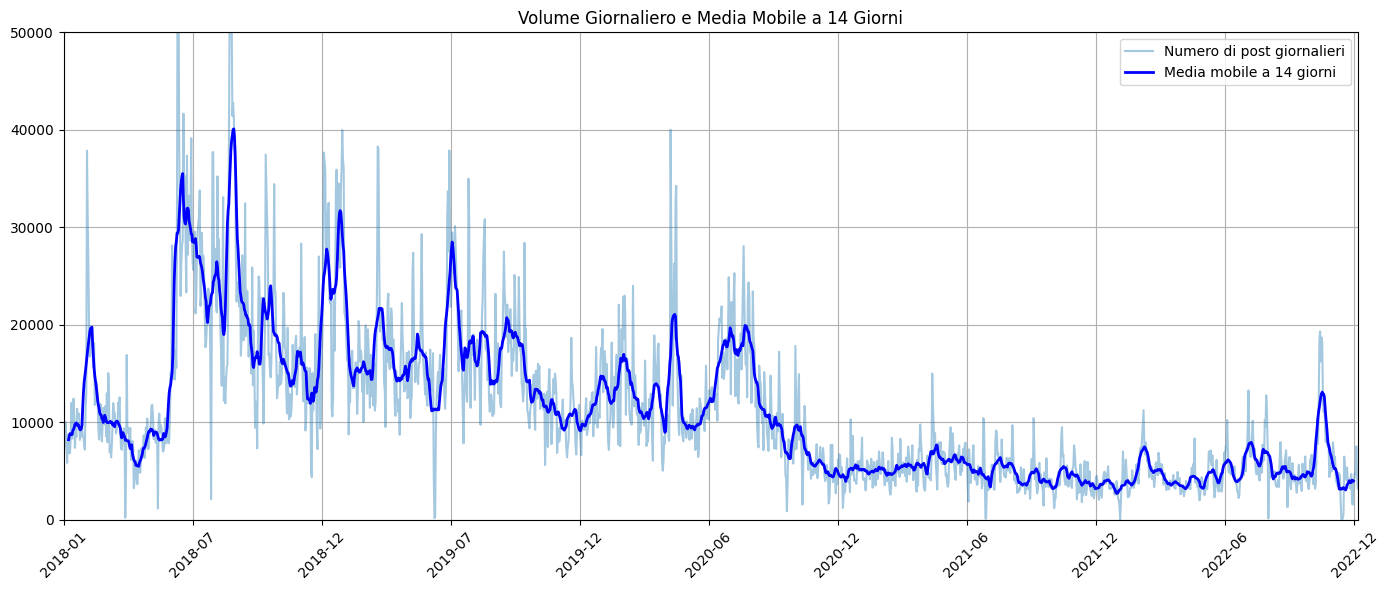

In [12]:
# Limiti temporali
start_date = df_sentiment["date"].min()
end_date = df_sentiment["date"].max()

# Tick ogni 6 mesi, incluso dicembre 2022
tick_dates = mdates.drange(start_date, end_date + timedelta(days=31), timedelta(days=182))

plt.figure(figsize=(14, 6))
plt.plot(df_sentiment["date"], df_sentiment["volume"], label="Numero di post giornalieri", alpha=0.4)
plt.plot(df_sentiment["date"], df_sentiment["volume_rolling_14d"], label="Media mobile a 14 giorni", color="blue", linewidth=2)

# Esempio: linea soglia per riferimento (opzionale)
# plt.axhline(y=10000, color='black', linestyle='--', linewidth=1.5, label='Soglia riferimento')

plt.ylim(0, 50000)
plt.xlim(start_date, end_date)

# Formattazione asse x
plt.gca().set_xticks(tick_dates)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.title("Volume Giornaliero e Media Mobile a 14 Giorni")
# plt.xlabel("Data")
# plt.ylabel("Volume Giornaliero")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("charts/hs_volume_giornaliero", dpi=300, bbox_inches='tight')

plt.show()


#### Indice di Sentiment

Calcolo il valore della base (assumendo come base il valore medio dell'indice nel 2018)

In [13]:
# Filtro i dati per il 2018 per calcolare la media di sentiment_score
df_sentiment["year"] = df_sentiment["date"].dt.year
base_2018 = df_sentiment[df_sentiment["year"] == 2018]["sentiment_score"].mean().round(4)


Calcolo l'indice normalizzato e la media mobile (2018 - 2022)

In [14]:
# Calcolo dell'indice normalizzato per gli anni 2018-2022 con base 2018
df_filtered = df_sentiment[df_sentiment["year"].isin([2018, 2019, 2020, 2021, 2022])].copy()
df_filtered["normalized_index"] = 100 + ((df_filtered["sentiment_score"] - base_2018) / abs(base_2018)) * 100

# Calcolo della media mobile a 14 giorni dell'indice normalizzato
df_filtered["rolling_14d"] = df_filtered["normalized_index"].rolling(window=14, center=True).mean()

# Calcolo della media mensile dell'indice normalizzato
df_filtered["month"] = df_filtered["date"].dt.to_period("M")
monthly_avg = df_filtered.groupby("month")["normalized_index"].mean().reset_index()
monthly_avg["month"] = monthly_avg["month"].dt.to_timestamp()



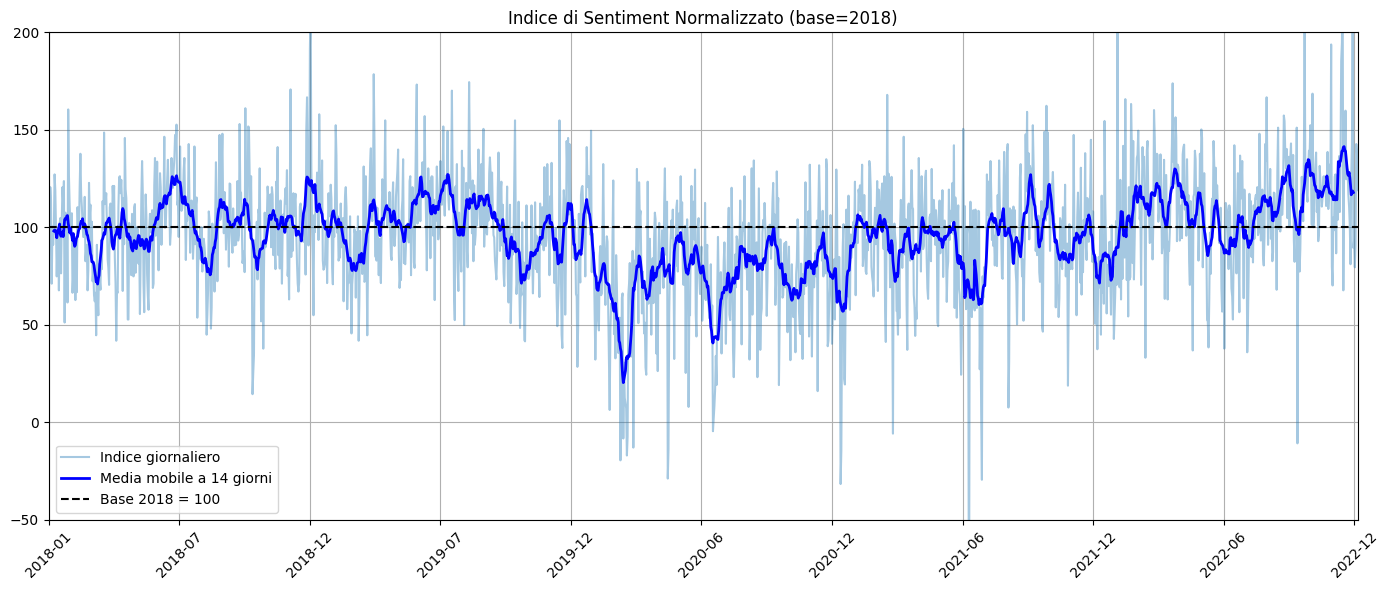

In [15]:
# Imposta i limiti min e max
start_date = df_filtered["date"].min()
end_date = df_filtered["date"].max()

# Genera i tick ogni 6 mesi, incluso l'ultimo
tick_dates = mdates.drange(start_date, end_date + timedelta(days=31), 
                           timedelta(days=182))  # ~6 mesi

# Grafico
plt.figure(figsize=(14, 6))
plt.plot(df_filtered["date"], df_filtered["normalized_index"], label="Indice giornaliero", alpha=0.4)
plt.plot(df_filtered["date"], df_filtered["rolling_14d"], label="Media mobile a 14 giorni", color="blue", linewidth=2)
plt.axhline(y=100, color='black', linestyle='--', linewidth=1.5, label='Base 2018 = 100')


plt.ylim(-50, 200)
plt.xlim(start_date, end_date)

# Imposta i tick personalizzati
plt.gca().set_xticks(tick_dates)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.title("Indice di Sentiment Normalizzato (base=2018)")
# plt.xlabel("Data")
# plt.ylabel("Indice normalizzato")
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()

plt.savefig("charts/hs_indice_sentiment_normalizzato.png", dpi=300, bbox_inches='tight')

plt.show()


### Fiducia dei consumatori

In [26]:
pd_fiducia = pd.read_csv("data/indice_fiducia.csv", sep=";")

In [28]:
# Rinomino le colonne per semplicità
pd_fiducia.columns = ["month", "confidence_index"]

# Rimozione dei valori mancanti e conversione dei tipi
pd_fiducia = pd_fiducia[pd_fiducia["confidence_index"] != ".."]
pd_fiducia["month"] = pd.to_datetime(pd_fiducia["month"], format="%Y-%m")
pd_fiducia["confidence_index"] = pd_fiducia["confidence_index"].astype(float)